2021-04-02 02:14:44,941 <ipython-input-1-d4f6825680af>:54 INFO Modeling nba 2018 Regular Season
2021-04-02 02:14:44,941 <ipython-input-1-d4f6825680af>:56 INFO Loading games
2021-04-02 02:14:45,261 <ipython-input-1-d4f6825680af>:58 INFO Initializing model
2021-04-02 02:14:59,985 <ipython-input-1-d4f6825680af>:60 INFO Fitting model
/home/jupyter/nba/pynba/team_stats.py:389: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self._trace = pm.sample(steps, init=init, **kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_ft_make_rate, off_ft_make_rate, sigma_pace, def_pace, off_pace, sigma_ft_attempt_rate, home_ft_attempt_rate, def_ft_attempt_rate, off_ft_attempt_rate, home_turnover_rate, def_turnover_rate, off_turnover_rate, home_off_reb_rat

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 363 seconds.
The number of effective samples is smaller than 25% for some parameters.
2021-04-02 02:24:06,121 <ipython-input-1-d4f6825680af>:62 INFO Saving results
2021-04-02 02:24:06,126 <ipython-input-1-d4f6825680af>:64 INFO Plotting & saving team ratings & pace
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Fallin

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 308 seconds.
The number of effective samples is smaller than 25% for some parameters.
2021-04-02 02:32:56,893 <ipython-input-1-d4f6825680af>:62 INFO Saving results
2021-04-02 02:32:56,895 <ipython-input-1-d4f6825680af>:64 INFO Plotting & saving team ratings & pace
2021-04-02 02:32:59,210 <ipython-input-1-d4f6825680af>:54 INFO Modeling nba 2020 Regular Season
2021-04-02 02:32:59,210 <ipython-input-1-d4f6825680af>:56 INFO Loading games
2021-04-02 02:32:59,457 <ipython-input-1-d4f6825680af>:58 INFO Initializing model
2021-04-02 02:33:16,319 <ipython-input-1-d4f6825680af>:60 INFO Fitting model
/home/jupyter/nba/pynba/team_stats.py:389: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self._trace = pm.sample(steps, init=init, *

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.
The number of effective samples is smaller than 25% for some parameters.
2021-04-02 02:40:25,768 <ipython-input-1-d4f6825680af>:62 INFO Saving results
2021-04-02 02:40:25,771 <ipython-input-1-d4f6825680af>:64 INFO Plotting & saving team ratings & pace


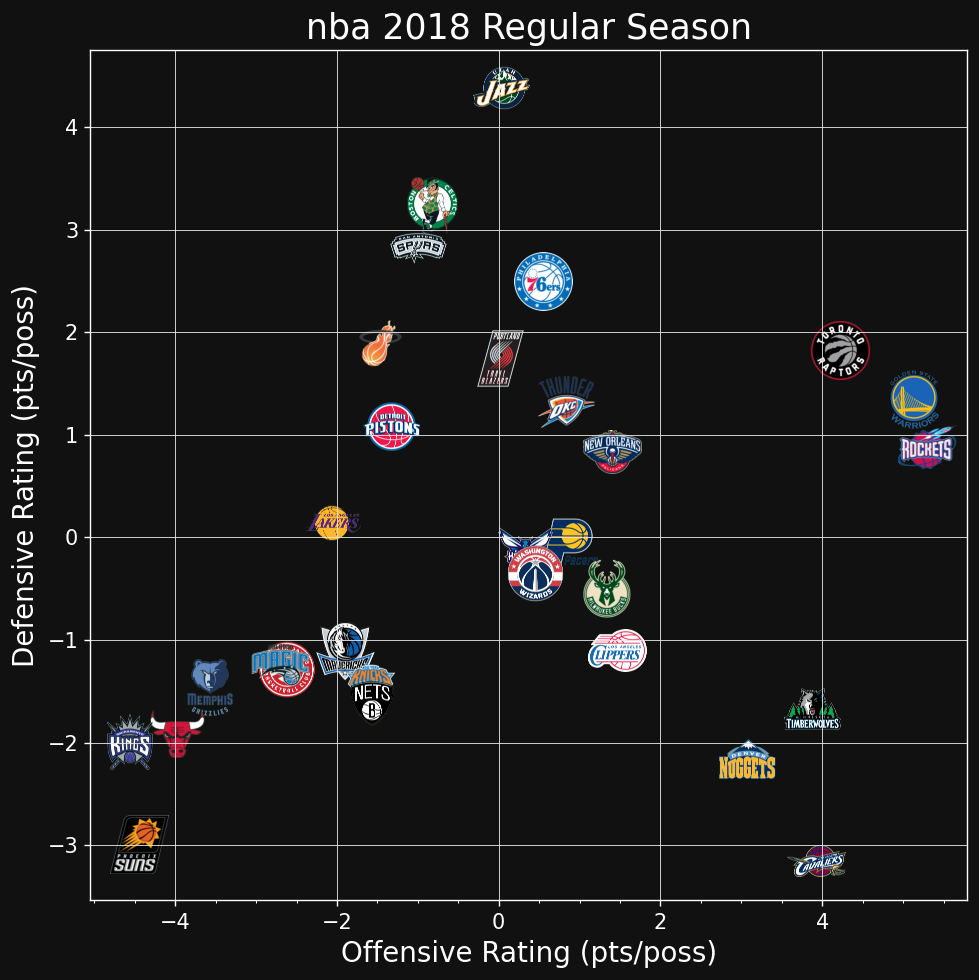

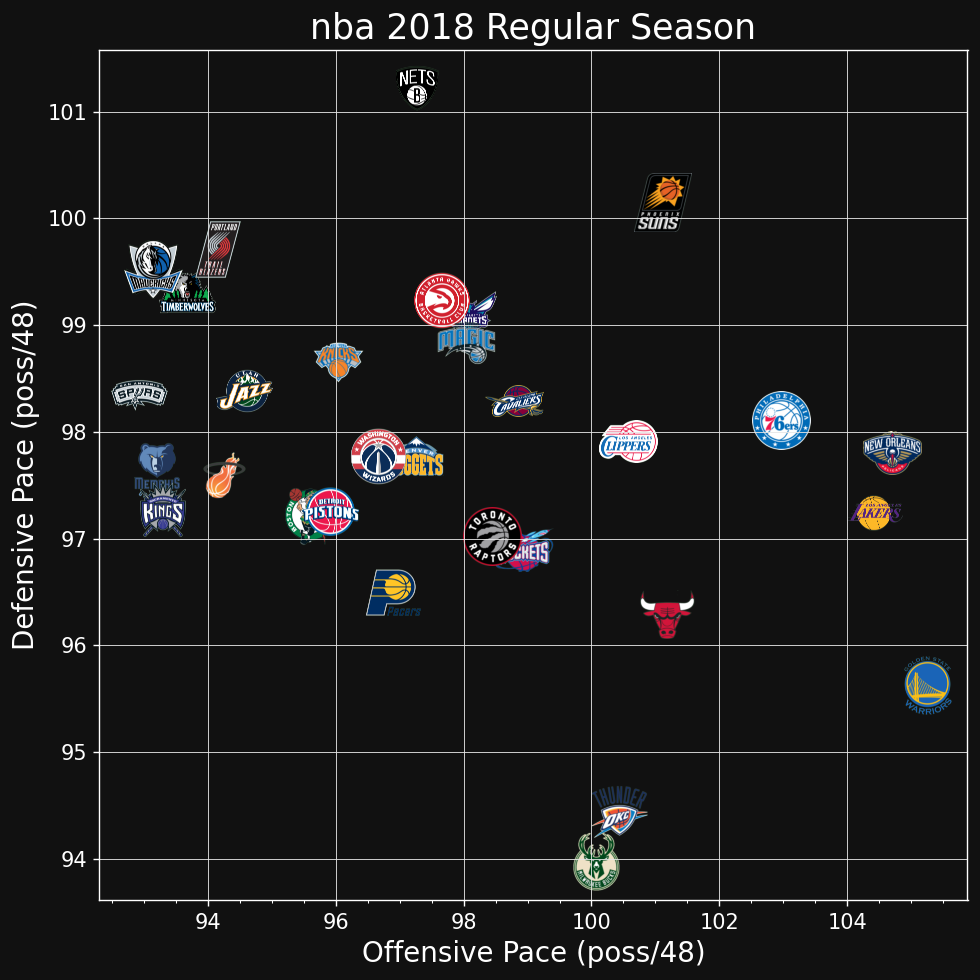

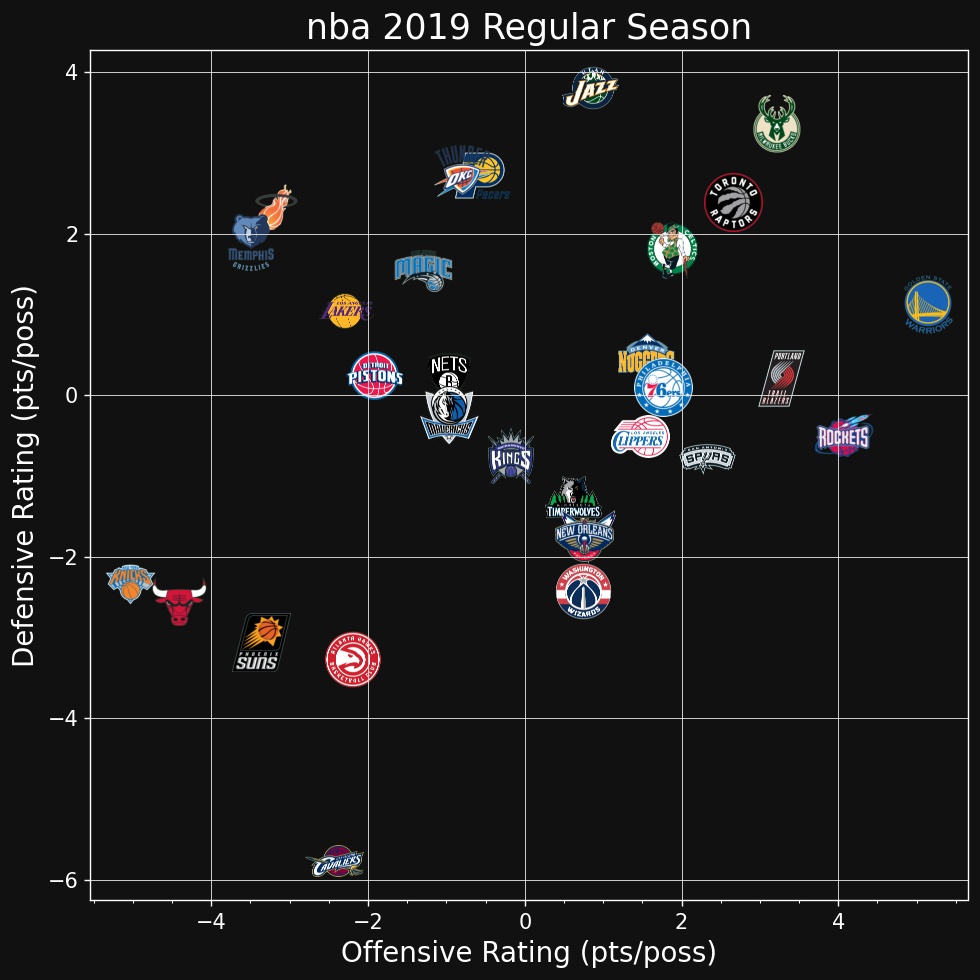

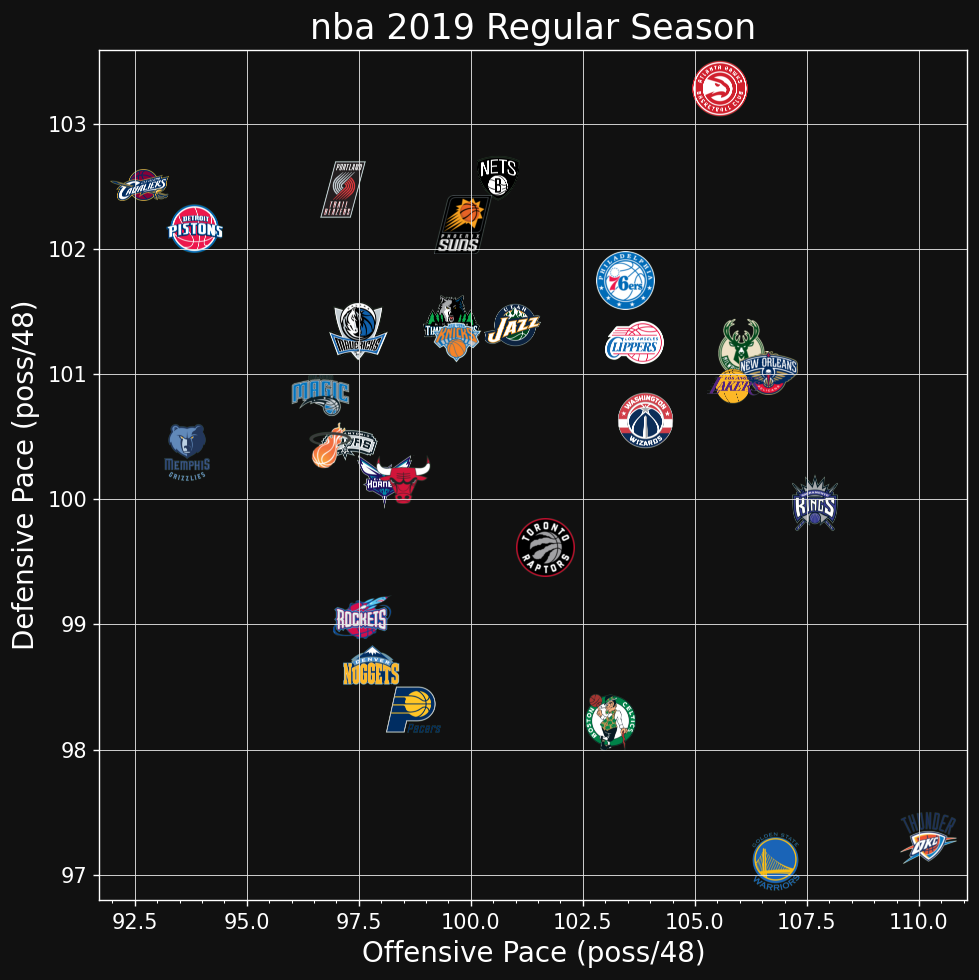

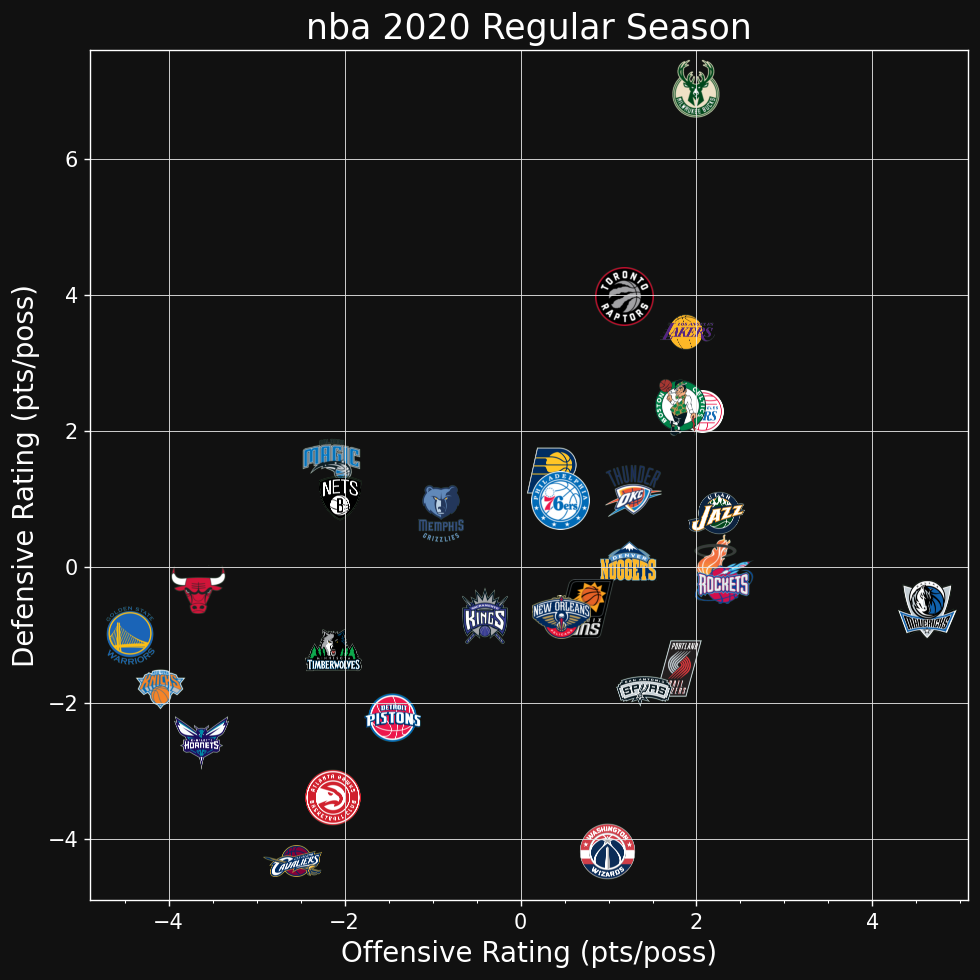

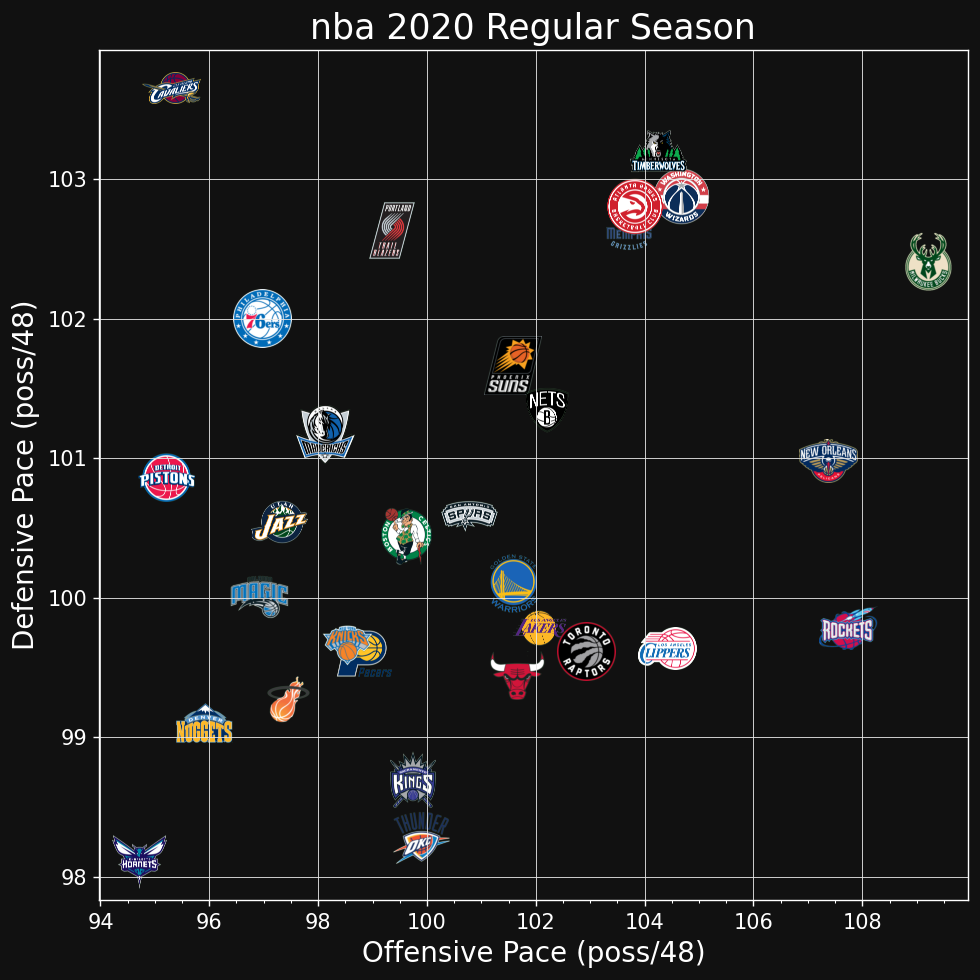

In [1]:
import logging
import os

from matplotlib import pyplot as plt

from pynba import blackontrans
from pynba.load_parsed_data import load_games
from pynba.team_stats import TeamsModel


DATA_PATH = "/home/jupyter/nba/notebooks/data/parsed_pbpstats"
OUTPUT_PATH = "/home/jupyter/nba/notebooks/data/modeled_results"
LEAGUE = 'nba'
SEASON_TYPE = 'Regular Season'
YEARS = [
#     2001,
#     2002,
#     2003,
#     2004,
#     2005,
#     2006,
#     2007,
#     2008,
#     2009,
#     2010,
#     2011,
#     2012,
#     2013,
#     2014,
#     2015,
#     2016,
#     2017,
    2018,
    2019,
    2020,
]


def configure_logging():
    logger = logging.getLogger('teams_inference')
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s %(module)s:%(lineno)d %(levelname)s %(message)s')
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)
    return logger


logger = configure_logging()


def model_year(year):
    logger.info(f'Modeling {LEAGUE} {year} {SEASON_TYPE}')
    filters = [[('year', '=', year), ('season_type', '=', SEASON_TYPE), ('league', '=', LEAGUE)]]
    logger.info('Loading games')
    games = load_games(DATA_PATH, filters=filters)
    logger.info('Initializing model')
    teams_model = TeamsModel(games)
    logger.info('Fitting model')
    teams_model.fit()
    logger.info('Saving results')
    teams_model.results.to_csv(os.path.join(OUTPUT_PATH, f"team_stats_{LEAGUE}_{year}_{SEASON_TYPE}.csv"), index=False)
    logger.info('Plotting & saving team ratings & pace')
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    teams_model.plot_ratings(ax)
    ax.set_title(f'{LEAGUE} {year} {SEASON_TYPE}')
    fig.savefig(os.path.join(OUTPUT_PATH, f"team_ratings_{LEAGUE}_{year}_{SEASON_TYPE}.png"))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    teams_model.plot_paces(ax)
    ax.set_title(f'{LEAGUE} {year} {SEASON_TYPE}');
    fig.savefig(os.path.join(OUTPUT_PATH, f"team_paces_{LEAGUE}_{year}_{SEASON_TYPE}.png"))


for year in YEARS:
    model_year(year)